# Распознавание лиц при помощи SVM и kernel trick

# Описание набора данных

В этом задании вам предлагается построить классификатор, обученный на изображениях лиц. Сначала загрузим необходимый набор данных и посмотрим, что он из себя представляет. 

Таблица содержит "распрямленные" представления изображений лиц людей.

Изначально каждое изображение — матрица размера $62 \times 47$, значения которой, предположительно, нормированы к диапазону $[0, 1]$ из диапазона $[0, 255] \cap \mathbb Z$. Сами значения отвечают за интенсивность пикселя: чем значение больше, тем пиксель светлее.

Обратите внимание, из картинки (или, что то же самое, матрицы) размера $62 \times 47$ получился вектор длины $2914 = 62 \cdot 47$.

Колонка <code>label</code> отвечает за имя человека, изображенного на картинке.

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('persons_pics_train.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell


Убедимся в том, что перед нами действительно изображения лиц людей. Возьмем первые $15$ строк из таблицы исходных данных и построим соответствующие им изображения.

In [2]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

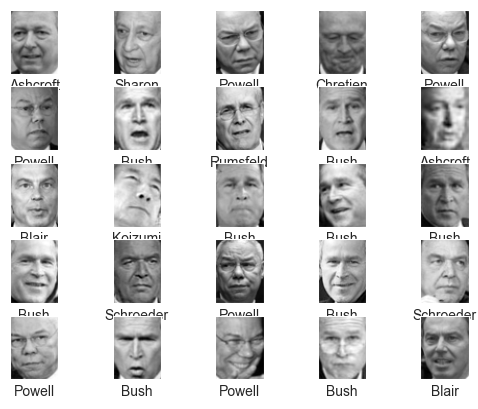

In [3]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')    

Крупнее

(-0.5, 46.5, 61.5, -0.5)

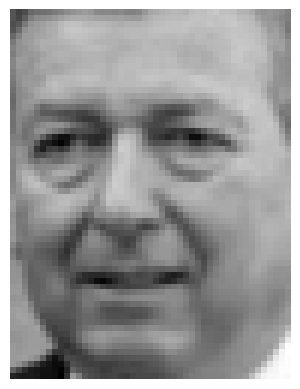

In [4]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# Немного озорства

Определите число различных людей, фотографии которых содержатся в рассматриваемом наборе данных.

In [5]:
totalpics = len(df['label'])
counter=0
for i in range(totalpics):
    if df['label'][i] == "Jacques Chirac":
        counter+=1
print(round(counter/totalpics,3))
people = set(df['label'])

0.033


Постройте гистограмму распределения объектов по классам и вычислите долю объектов каждого класса. 

In [6]:
peoples_pics = []
peoples_names = []
# print(list(df[str(0)][:]))

for j in range(len(people)):
    string = []
    for i in range(totalpics):
        if df['label'][i] == list(people)[j]:
            string.append(list(df.iloc[i])[:-1])
    peoples_pics.append(string)
    peoples_names.append(list(people)[j])


In [7]:
peoples_names

['Jacques Chirac',
 'John Ashcroft',
 'Hugo Chavez',
 'Colin Powell',
 'George W Bush',
 'Ariel Sharon',
 'Gerhard Schroeder',
 'Serena Williams',
 'Donald Rumsfeld',
 'Junichiro Koizumi',
 'Tony Blair',
 'Jean Chretien']

In [8]:
sum = 0
for i in range(12):
    sum+=len(peoples_pics[i])/totalpics
print(sum)

0.9999999999999999


In [9]:
peoples_pics_avg = []
for i in range(len(people)):
    peoples_pics_avg.append(np.average(peoples_pics[i], axis=0))

In [10]:
peoples_pics_avg[0]

array([0.34800952, 0.36815212, 0.40570411, ..., 0.50585266, 0.45662508,
       0.43499704])


На основе имеющихся данных поставьте в соответствие каждому человеку один вектор, координаты которого являются средним соответствующих координат всех векторов, отождествленных с этим человеком.

In [11]:
peoples_names

['Jacques Chirac',
 'John Ashcroft',
 'Hugo Chavez',
 'Colin Powell',
 'George W Bush',
 'Ariel Sharon',
 'Gerhard Schroeder',
 'Serena Williams',
 'Donald Rumsfeld',
 'Junichiro Koizumi',
 'Tony Blair',
 'Jean Chretien']

(-0.5, 46.5, 61.5, -0.5)

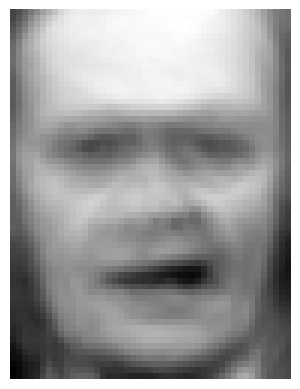

In [12]:
plt.imshow(peoples_pics_avg[11].astype(float).reshape(62,47), cmap='gray')
plt.axis('off')

Вычислите координату с индексом $0$ усредненного вектора, соответствующего человеку из вашего индивидуального задания.

In [13]:
# < ENTER YOUR CODE HERE > 

Используя усредненные векторы, постройте изображения всех людей из набора данных.

In [14]:
# < ENTER YOUR CODE HERE > 

В качестве меры "схожести" двух объектов часто используют так называемое [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity). Не следует путать с косинусным расстоянием.

Постройте матрицу "схожести" объектов на основе их усредненных векторов. Для визуализации рекомендуем использовать тепловую карту, например, [из библиотеки seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [15]:
nums1 = peoples_pics_avg[6]
nums2 = peoples_pics_avg[7]
print(nums1)
print(nums2)

[0.21016235 0.22821    0.26825498 ... 0.42847706 0.4268747  0.41111815]
[0.41298277 0.39043376 0.35909092 ... 0.33449198 0.34824719 0.36185384]


In [16]:
np.dot(nums1, nums2)

538.2648828807149

In [17]:
(np.linalg.norm(nums1) * np.linalg.norm(nums2))

546.0472954413467

In [18]:
cosine_similarity = np.dot(nums1, nums2) / (np.linalg.norm(nums1) * np.linalg.norm(nums2))

In [19]:
print(cosine_similarity)

0.9857477316972304


Определите косинусное сходство для пары людей из вашего индивидуального задания на основе соответствующих им "усредненных" векторов.

In [20]:
# < ENTER YOUR CODE HERE > 

# Построение модели

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке <code>label</code>.

In [21]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df.drop(columns='label'), 
    df['label'], 
    test_size=0.2, 
    random_state=5, 
    stratify=df['label']
)


print(X_train)
print(X_test)

             0         1         2         3         4         5         6  \
1216  0.316340  0.389543  0.275817  0.192157  0.371242  0.466667  0.479739   
259   0.317647  0.379085  0.304575  0.265360  0.424837  0.490196  0.470588   
941   0.186928  0.214379  0.218301  0.295425  0.473203  0.585621  0.594771   
42    0.814379  0.794771  0.797386  0.746405  0.694118  0.733333  0.588235   
1300  0.069281  0.091503  0.236601  0.471895  0.530719  0.535948  0.522876   
...        ...       ...       ...       ...       ...       ...       ...   
777   0.389543  0.393464  0.386928  0.367320  0.433987  0.521569  0.569935   
642   0.401307  0.433987  0.454902  0.477124  0.556863  0.722876  0.816994   
1198  0.456209  0.490196  0.541176  0.586928  0.624837  0.640523  0.662745   
458   0.155556  0.173856  0.173856  0.177778  0.243137  0.332026  0.375163   
398   0.082353  0.124183  0.164706  0.211765  0.298039  0.376471  0.423529   

             7         8         9  ...      2904      2905    

## Первое приближение: базовый SVM классификатор с линейным ядром.

Обучите модель <code>SVC()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании.

In [22]:
from sklearn import svm

clf = svm.SVC(kernel='linear', random_state=5)

Оцените модель на тестовых данных. Вычислите <code>f1_score(average='weighted')</code>

In [23]:
# < ENTER YOUR CODE HERE > 

В целом, достаточно неплохой результат, но имеет смысл попробовать подобрать параметры.

## Подбор гиперпараметров

Используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей

In [24]:
from sklearn import model_selection

tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[5]}]


cv = model_selection.GridSearchCV(svm.SVC(), tuned_parameters, refit=True, verbose=3)

Определите гиперпараметры лучшей полученной модели.

In [25]:
from sklearn import metrics

In [26]:
model = svm.SVC(kernel='linear', random_state=5)
model.fit(X_train, y_train)

# Оценка модели на тестовых данных
y_pred = model.predict(X_test)

# Вычисление f1_score с average='weighted'
f1 = metrics.f1_score(y_test, y_pred, average='weighted')

print(f'F1 Score (weighted): {f1}')

F1 Score (weighted): 0.7408103886614767


Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>.

In [27]:
import time
# Определение параметров для GridSearchCV
tuned_parameters = [
    {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': [1e-3, 1e-4],
        'C': [1, 10, 100, 1000],
        'class_weight': [None, 'balanced'],
        'random_state': [5]
    }
]

# Инициализация GridSearchCV
cv = model_selection.GridSearchCV(svm.SVC(), tuned_parameters, refit=True, verbose=3)

# Запуск подбора гиперпараметров и измерение времени обучения
start_time = time.time()
cv.fit(X_train, y_train)
end_time = time.time()

# Вывод результатов
print(f"Лучшие параметры: {cv.best_params_}")
print(f"Время обучения: {end_time - start_time:.2f} секунд")

# Оценка лучшей модели на тестовых данных
best_model = cv.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.778 total time=   0.8s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.764 total time=   0.7s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.825 total time=   0.8s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.802 total time=   0.7s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.769 total time=   0.7s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.377 total time=   1.0s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.358 total time=   1.0s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.373 total time=   1.0s
[CV 4/5] END C=1, class_weight=None, gam

In [33]:
# Предсказания
predictions = best_model.predict(df_new)

# Вывод предсказаний в виде списка
print(f'Предсказания: {predictions.tolist()}')

Предсказания: ['George W Bush', 'Donald Rumsfeld', 'Jacques Chirac', 'Jacques Chirac', 'Tony Blair', 'Colin Powell', 'Donald Rumsfeld', 'Colin Powell', 'Tony Blair', 'George W Bush', 'Gerhard Schroeder', 'Hugo Chavez', 'George W Bush', 'Hugo Chavez', 'Ariel Sharon', 'George W Bush', 'Ariel Sharon', 'Colin Powell', 'John Ashcroft', 'Gerhard Schroeder', 'Ariel Sharon', 'George W Bush', 'Colin Powell', 'George W Bush', 'George W Bush', 'Donald Rumsfeld', 'Donald Rumsfeld', 'Tony Blair', 'Serena Williams', 'Jean Chretien', 'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush', 'Tony Blair', 'Colin Powell', 'Donald Rumsfeld', 'Colin Powell', 'George W Bush', 'Gerhard Schroeder', 'Colin Powell', 'Donald Rumsfeld', 'Gerhard Schroeder', 'George W Bush', 'Tony Blair', 'George W Bush', 'George W Bush', 'Tony Blair', 'Colin Powell', 'Tony Blair', 'Serena Williams', 'Jean Chretien', 'Tony Blair', 'George W Bush', 'Colin Powell', 'George W Bush', 'George W Bush', 'George W Bush', 'Geor

In [44]:
clf = svm.SVC(C=1000, class_weight='balanced', gamma=0.0001, kernel='sigmoid', random_state=5)
clf.fit(df.drop(columns='label'), df['label'])
predictions1 = clf.predict(df_new)

clf = svm.SVC(C=10000, class_weight='balanced', gamma=0.0001, kernel='sigmoid', random_state=5)
clf.fit(df.drop(columns='label'), df['label'])
predictions2 = clf.predict(df_new)

In [48]:
predictions2

array(['George W Bush', 'Ariel Sharon', 'Jacques Chirac',
       'Jacques Chirac', 'Tony Blair', 'Colin Powell', 'Donald Rumsfeld',
       'Colin Powell', 'Tony Blair', 'George W Bush', 'Donald Rumsfeld',
       'Hugo Chavez', 'George W Bush', 'Hugo Chavez', 'Colin Powell',
       'George W Bush', 'Ariel Sharon', 'Colin Powell', 'John Ashcroft',
       'Gerhard Schroeder', 'Ariel Sharon', 'George W Bush',
       'Colin Powell', 'George W Bush', 'George W Bush',
       'Donald Rumsfeld', 'Donald Rumsfeld', 'Tony Blair',
       'Serena Williams', 'Jean Chretien', 'George W Bush',
       'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush',
       'Colin Powell', 'Donald Rumsfeld', 'Jacques Chirac',
       'George W Bush', 'Gerhard Schroeder', 'Colin Powell',
       'Donald Rumsfeld', 'Gerhard Schroeder', 'George W Bush',
       'Tony Blair', 'George W Bush', 'George W Bush', 'Tony Blair',
       'Colin Powell', 'Tony Blair', 'Serena Williams', 'Jean Chretien',
       'Tony 

In [45]:

from collections import Counter

In [47]:
res = list((Counter(predictions1) - Counter(predictions2)).elements())
 
# print result
print("The list after performing the subtraction : " + str(res))

The list after performing the subtraction : ['Ariel Sharon', 'Ariel Sharon', 'Tony Blair', 'Tony Blair', 'Colin Powell', 'Colin Powell', 'Colin Powell', 'Hugo Chavez']


In [39]:

# Вычисление f1_score с average='weighted'
f1 = metrics.f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score (weighted): {f1}')

F1 Score (weighted): 0.770802678845364


## Уменьшение размерности

Обучение было долгим. Имеет смысл проверить, что будет если уменьшить размерность входных данных, например, при помощи <code>PCA</code>. Обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных и определите минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше <code>0.95</code>.

In [29]:
from sklearn import decomposition

In [30]:
# Обучение модели PCA
pca = decomposition.PCA(svd_solver='full')
pca.fit(X_train)

# Вычисление объясненной дисперсии
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Определение минимального количества компонент для объяснения более 95% дисперсии
n_components = np.argmax(explained_variance >= 0.95) + 1

print(f'Минимальное количество компонент для объяснения более 95% дисперсии: {n_components}')

Минимальное количество компонент для объяснения более 95% дисперсии: 173


Заново обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных с использованием полученного числа ГК. Примените полученное преобразование для тренировочных и тестовых данных.

In [34]:
# Обучение PCA с полученным числом компонент
pca = decomposition.PCA(n_components=n_components, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Определение параметров для GridSearchCV
tuned_parameters = [
    {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': [1e-3, 1e-4],
        'C': [1, 10, 100, 1000],
        'class_weight': [None, 'balanced'],
        'random_state': [5]
    }
]

# Инициализация GridSearchCV
cv = model_selection.GridSearchCV(svm.SVC(), tuned_parameters, refit=True, verbose=3)

# Запуск подбора гиперпараметров и измерение времени обучения
start_time = time.time()
cv.fit(X_train_pca, y_train)
end_time = time.time()

# Вывод результатов
print(f"Лучшие параметры: {cv.best_params_}")
print(f"Время обучения: {end_time - start_time:.2f} секунд")

# Оценка лучшей модели на тестовых данных
best_model = cv.best_estimator_
y_pred = best_model.predict(X_test_pca)

# Вычисление f1_score с average='weighted'
f1 = metrics.f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score (weighted): {f1}')

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.745 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.750 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.811 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.764 total time=   0.0s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.745 total time=   0.0s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.344 total time=   0.0s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.340 total time=   0.0s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.340 total time=   0.0s
[CV 4/5] END C=1, class_weight=None, gam

KeyboardInterrupt: 

Для полученных после <code>PCA</code> данных аналогично проделанному ранее, то есть используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей.

In [ ]:
# < ENTER YOUR CODE HERE > 

Определите гиперпараметры лучшей полученной модели.

In [ ]:
# < ENTER YOUR CODE HERE > 

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>

In [32]:
df_new = pd.read_csv('persons_pics_reserved.csv')
df_new.head()

,0,1,2,3,4,5,6,7,8,9,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
0,0.315033,0.393464,0.517647,0.636601,0.652288,0.653595,0.677124,0.725490,0.716340,0.695425,...,0.031373,0.047059,0.047059,0.053595,0.050980,0.036601,0.027451,0.011765,0.007843,0.003922
1,0.518954,0.664052,0.690196,0.627451,0.576471,0.575163,0.605229,0.633987,0.666667,0.684967,...,0.568627,0.583007,0.577778,0.549020,0.479739,0.403922,0.427451,0.569935,0.772549,0.924183
2,0.196078,0.205229,0.219608,0.197386,0.179085,0.223529,0.295425,0.363399,0.411765,0.471895,...,0.471895,0.479739,0.486274,0.511111,0.528105,0.556863,0.586928,0.611765,0.610458,0.627451
3,0.330719,0.376471,0.413072,0.420915,0.430065,0.454902,0.477124,0.486274,0.487582,0.494118,...,0.688889,0.715033,0.724183,0.695425,0.308497,0.126797,0.125490,0.125490,0.111111,0.109804
4,0.405229,0.428758,0.487582,0.567320,0.619608,0.648366,0.665359,0.686275,0.701961,0.717647,...,0.611765,0.630065,0.627451,0.746405,0.700654,0.200000,0.099346,0.095425,0.087582,0.083660


Видно, что качество модели изменилось незначительно, при этом время обучения существенно сократилось.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df.drop(columns='label'), 
    df['label'], 
    test_size=0.2, 
    random_state=5, 
    stratify=df['label']
)

# Обучение PCA для уменьшения размерности
pca = decomposition.PCA(svd_solver='full')
pca.fit(X_train)

# Определение минимального количества компонент для объяснения более 95% дисперсии
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1

# Обучение PCA с полученным числом компонент
pca = decomposition.PCA(n_components=n_components, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Подбор гиперпараметров с использованием GridSearchCV
tuned_parameters = [
    {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': [1e-3, 1e-4],
        'C': [1, 10, 100, 1000],
        'class_weight': [None, 'balanced'],
        'random_state': [5]
    }
]

cv = model_selection.GridSearchCV(svm.SVC(), tuned_parameters, refit=True, verbose=3)
cv.fit(X_train_pca, y_train)

# Оценка лучшей модели на тестовых данных
best_model = cv.best_estimator_
y_pred = best_model.predict(X_test_pca)

In [ ]:
# Предсказания
predictions = best_model.predict(new_data_pca)

# Вывод предсказаний в виде списка
print(f'Предсказания: {predictions.tolist()}')